In [1]:
# Importing libraries for analysis
import numpy as np
import pandas as pd

import datetime
import os
import zipfile

from dateutil import relativedelta
import calendar
from operator import attrgetter

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Creating a function to find a *.zip file
def find_name():
    for p in os.listdir():
        if p.endswith(".zip"):
            return p

In [3]:
# Extracting datasets from a *.zip file
with zipfile.ZipFile(find_name(), "r") as zipref:
    zipref.extractall()

In [4]:
# Creating basic dataframes for analysis
customers = pd.read_csv('customers_dataset.csv')
orders = pd.read_csv('orders_dataset.csv')
items = pd.read_csv('items_dataset.csv')

* customers - таблица с уникальными индетификаторами пользователей
* orders - таблица заказов
* items - таблица товарных позиций, входящие в заказ

In [5]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


### Finding the number of users who made only one purchase

In [8]:
# Merging two dataframes
df1 = orders.merge(customers)

In [9]:
# Replacing all NaN values by zero
df1 = df1.fillna(0)

# Filtering of unpaid orders
df1 = df1.query('order_approved_at != 0')

In [10]:
# Grouping purchases by paid orders
df1 = df1.groupby('order_approved_at', as_index=False)\
            .agg({'order_id': 'count'})\
            .rename(columns={'order_id': 'order_count'})

In [11]:
# Finding users who have made only one purchase
single_order = df1.query('order_count == 1').shape[0]
print('The data contains {} users who have made only one purchase'.format(single_order))

The data contains 83688 users who have made only one purchase


### Determining the average number of non-deliverable orders per month

In [12]:
# Formatting the date in database
orders.order_approved_at = pd.to_datetime(orders.order_approved_at)

In [13]:
# Finding the earliest date
start_order_date = orders.order_approved_at.min()

# Finding the latest date
end_order_date = orders.order_approved_at.max()

In [14]:
# Determining the number of months contained in the dataset
month_count = round((end_order_date - start_order_date).days / 30)

print('The dataset has {} months'.format(month_count))

The dataset has 24 months


In [15]:
#Let's see the number of orders and information on all order statuses except 'delivered'
orders.query("order_status != 'delivered'")\
    .order_status\
    .value_counts()

shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: order_status, dtype: int64

##### *The database contains a large number of undelivered orders to the customers for various reasons. Let's take a closer look at all the reasons for non-delivery of items.*

In [16]:
# Creating a function to determine the average value for different reasons
def check_details(status):
    return round(orders.query("order_status == @status")\
                        .order_status\
                        .count() / month_count, 2)

In [17]:
# Shipment of items from warehouse
status_shipped = check_details('shipped')
print(f"""The average number of orders per month that were not delivered due to the fact 
that the products are shipped from the warehouse and the items are in transit to the recipient = {status_shipped} orders.""")

# Canceled orders
status_canceled = check_details('canceled')
print(f"""\nAverage number of orders per month that were not delivered 
because the recipient canceled the order = {status_canceled} orders.""")

# Unavailable orders
status_unavailable = check_details('unavailable')
print(f"""\nAverage number of orders per month that were not delivered 
because the order is now unavailable = {status_unavailable} orders.""")

# Invoiced orders
status_invoiced = check_details('invoiced')
print(f"""\nAverage number of orders per month that were not delivered 
due to waiting for customer order formation = {status_invoiced} orders.""")

# Processing the assembly of items
status_processing = check_details('processing')
print(f"""\nAverage number of orders per month that were not delivered 
because a customer's order was in processing = {status_processing} orders.""")

# Created orders
status_created = check_details('created')
print(f"""\nAverage number of orders per month that were not delivered
because a customer just created an order = {status_created} orders.""")

# Approved orders
status_approved = check_details('approved')
print(f"""\nAverage number of orders per month that were not delivered
due to customers confirmation = {status_approved} orders.""")

The average number of orders per month that were not delivered due to the fact 
that the products are shipped from the warehouse and the items are in transit to the recipient = 46.12 orders.

Average number of orders per month that were not delivered 
because the recipient canceled the order = 26.04 orders.

Average number of orders per month that were not delivered 
because the order is now unavailable = 25.38 orders.

Average number of orders per month that were not delivered 
due to waiting for customer order formation = 13.08 orders.

Average number of orders per month that were not delivered 
because a customer's order was in processing = 12.54 orders.

Average number of orders per month that were not delivered
because a customer just created an order = 0.21 orders.

Average number of orders per month that were not delivered
due to customers confirmation = 0.08 orders.


### Determing the favorite day of the week on which a product is most often purchased

In [18]:
# Merging databases and leaving columns 'product_id' and 'order_purchase_timestamp'
df2 = items.merge(orders)[['product_id', 'order_purchase_timestamp']]

df2.head()

,product_id,order_purchase_timestamp
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 08:59:02
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 10:53:06
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:33:31
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:00:35
4,ac6c3623068f30de03045865e4e10089,2017-02-04 13:57:51


In [19]:
# Creating a function to convert the date to the format of the day of the week
def get_weekdays(d):
    return datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').strftime('%A')

In [20]:
# Adding a new column with the day of the week of the purchase
df2['weekday'] = df2.order_purchase_timestamp.apply(get_weekdays)

df2.head()

,product_id,order_purchase_timestamp,weekday
0,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 08:59:02,Wednesday
1,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 10:53:06,Wednesday
2,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:33:31,Sunday
3,7634da152a4610f1595efa32f14722fc,2018-08-08 10:00:35,Wednesday
4,ac6c3623068f30de03045865e4e10089,2017-02-04 13:57:51,Saturday


In [21]:
# Creating a dataframe with a count of the number of orders of each item
df3 = df2.groupby(['product_id', 'weekday'], as_index=False)\
        .agg({'order_purchase_timestamp': 'count'})

df3.head()

,product_id,weekday,order_purchase_timestamp
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


In [22]:
# Creating a dataframe with a count of the maximum number of orders of each item
df4 = df3.groupby('product_id', as_index=False)\
        .agg({'order_purchase_timestamp': 'max'})

df4.head()

,product_id,order_purchase_timestamp
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,1
4,000d9be29b5207b54e86aa1b1ac54872,1


In [23]:
# Merging the two dataframes to determine the most common purchase day of the week
df5 = df4.merge(df3)[['product_id', 'weekday']]

df5

,product_id,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000b8f95fcb9e0096488278317764d19,Wednesday
...,...,...
42700,fff6177642830a9a94a0f2cba5e476d1,Sunday
42701,fff81cc3158d2725c0655ab9ba0f712c,Monday
42702,fff9553ac224cec9d15d49f5a263411f,Friday
42703,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


##### *Some products have several popular days to buy*

### Finding the average number of purchases per week for each customer

In [24]:
# Merging databases for analysis
orders_customers = orders\
                    .merge(customers)[['customer_id'
                                       , 'customer_unique_id'
                                       , 'order_purchase_timestamp']]

orders_customers.head()

,customer_id,customer_unique_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39


In [25]:
# Formatting the 'order_purchase_timestamp' into a date, leaving the year and month
orders_customers['order_purchase_timestamp'] = pd.to_datetime(orders_customers.order_purchase_timestamp)
orders_customers.order_purchase_timestamp = orders_customers.order_purchase_timestamp\
                                                            .apply(lambda d: d.strftime('%Y-%m'))

orders_customers.head()

,customer_id,customer_unique_id,order_purchase_timestamp
0,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,2018-07
2,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,2018-08
3,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,2017-11
4,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,2018-02


In [26]:
# Counting the number of unique purchases for each user in each month.
df6 = orders_customers.groupby(['customer_unique_id', 'order_purchase_timestamp'], as_index=False)\
                    .agg({'customer_id': 'count'})\
                    .rename(columns={'customer_id': 'purchases'})\
                    .sort_values('purchases', ascending=False)

df6.head()

,customer_unique_id,order_purchase_timestamp,purchases
7325,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6
50622,83e7958a94bd7f74a9414d8782f87628,2017-01,4
76793,c8460e4251689ba205045f3ea17884a1,2018-08,4
67755,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4
62196,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4


In [27]:
# Creating a function to find the number of weeks in a month
def get_number_week(d):
    year, month = d.split('-')
    return calendar.monthrange(int(year), int(month))[1]

In [28]:
# Creating a column for the number of weeks in the corresponding month
df6['count_week'] = df6.order_purchase_timestamp\
                        .apply(get_number_week)\
                        .div(7)\
                        .round(2)

In [29]:
# Calculating the average number of purchases per user per week
df6['purchases_per_week'] = df6.purchases\
                                .div(df6.count_week)\
                                .round(2)

df6

,customer_unique_id,order_purchase_timestamp,purchases,count_week,purchases_per_week
7325,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,4.43,1.35
50622,83e7958a94bd7f74a9414d8782f87628,2017-01,4,4.43,0.90
76793,c8460e4251689ba205045f3ea17884a1,2018-08,4,4.43,0.90
67755,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4,4.29,0.93
62196,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,4.00,1.00
...,...,...,...,...,...
32869,55a08a9545274dc36a0c5804389217d4,2017-03,1,4.43,0.23
32868,55a03f067a142cdde9f79f95a161b257,2018-01,1,4.43,0.23
32867,559df1e714566692202143c82bf531ca,2018-03,1,4.43,0.23
32866,559c99ed25c0bfe03e2e037c3205e9b6,2017-09,1,4.29,0.23


##### *The average number of purchases for each customers is **0.23** items per week*

### Performing a Cohort Analysis of the data and find the highest Retention Rate in the third month

In [30]:
# Users who made a purchase within one month will be selected as a cohort
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)

In [31]:
# Creating the dataframe necessary for analysis
df7 = orders.merge(customers)[['customer_unique_id', 'order_purchase_timestamp']]

df7.head()

,customer_unique_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39


In [32]:
# Defining the month in which the product was purchased by the user
df7['month'] = df7.order_purchase_timestamp\
                    .dt\
                    .to_period('M')

In [33]:
# Determining the month of the very first purchase made by the user
df7['cohort'] = df7.groupby('customer_unique_id')['order_purchase_timestamp']\
                    .transform('min')\
                    .dt\
                    .to_period('M')

In [34]:
df7.head()

,customer_unique_id,order_purchase_timestamp,month,cohort
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,2018-02


In [35]:
# Creating a new dataframe for the cohort
df_cohort = df7.groupby(['cohort', 'month'], as_index=False)\
                .agg(num_customers=('customer_unique_id', 'nunique'))  # number of users in a cohort

# Determining after how many months a second purchase was made
df_cohort['num_period'] = df_cohort.month\
                                    .sub(df_cohort.cohort)\
                                    .apply(attrgetter('n'))

In [36]:
# Creating a pivot table
cohort_pivot = df_cohort.pivot(index='cohort'
                              , columns='num_period'
                              , values='num_customers')

cohort_pivot

num_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


In [37]:
# Determining the Retention Rate
size = cohort_pivot.iloc[:, 0]  # first cohort value (number of users)
retention = cohort_pivot.div(size, axis='index')

retention

num_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003115,NaN,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,0.006231,0.006231
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,NaN,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309,NaN
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN,NaN
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517,NaN,NaN
2017-04,1.0,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN,NaN,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,NaN,NaN,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,NaN,NaN,NaN,NaN,NaN


In [38]:
# Next, for clarity, I apply a style, add symbols and translate values ​​into percentages
retention_style = (retention.style
                    .set_caption('User retention by cohort')  # add signature
                    .background_gradient(cmap='winter')  # coloring cells by columns
                    .highlight_null('black')  # make the background black for NaN values
                    .format("{:.2%}", na_rep=""))  # format float to percentage, get rid of NaN values

retention_style

num_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.31%,,,0.31%,,0.31%,,0.31%,,0.31%,,0.31%,0.62%,0.62%
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.52%,0.13%,0.13%,,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%,
2017-02,100.00%,0.23%,0.29%,0.11%,0.40%,0.11%,0.23%,0.17%,0.17%,0.23%,0.11%,0.29%,0.17%,0.17%,0.11%,0.06%,0.06%,0.23%,,
2017-03,100.00%,0.49%,0.38%,0.38%,0.34%,0.15%,0.15%,0.30%,0.34%,0.08%,0.38%,0.15%,0.23%,0.11%,0.15%,0.23%,0.08%,0.15%,,
2017-04,100.00%,0.60%,0.21%,0.17%,0.34%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.21%,,,
2017-05,100.00%,0.50%,0.50%,0.39%,0.31%,0.33%,0.42%,0.17%,0.25%,0.31%,0.25%,0.33%,0.25%,0.03%,0.19%,0.25%,,,,
2017-06,100.00%,0.48%,0.35%,0.41%,0.25%,0.38%,0.38%,0.22%,0.13%,0.22%,0.32%,0.35%,0.16%,0.13%,0.19%,,,,,


##### *As can be seen from the Cohort Analysis, the Retention Rate in the third month of 2017-06 is **0.41%**.*

### Performing an RFM Analysis of the data for each user and average the RFM-metrics for each cluster

*For RFM Analysis, data from the columns will be used:*
- `customer_unique_id`;
- `order_purchase_timestamp`;
- `product_id`;
- `price`.

In [39]:
# Merging dataframes for analysis
df8 = customers.merge(orders)\
                .merge(items)[['customer_unique_id'
                              , 'order_purchase_timestamp'
                              , 'product_id'
                              , 'price']]

df8.head()

,customer_unique_id,order_purchase_timestamp,product_id,price
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,a9516a079e37a9c9c36b9b78b10169e8,124.99
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,4aa6014eceb682077f9dc4bffebc05b0,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,bd07b66896d6f1494f5b86251848ced7,139.94
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,a5647c44af977b148e0a3a4751a09e2e,149.94
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,9391a573abe00141c56e38d84d7d5b3b,230.00


In [40]:
# Finding the last date of the purchase to build on it in the future
last_purchase = df8.order_purchase_timestamp.max()

last_purchase

Timestamp('2018-09-03 09:06:57')

*Three main indicators of consumer behavior:*
- **recency (r)** - *number of days since last purchase*;
- **frequency (f)** - *shopping frequency*;
- **monetary (m)** - *the total amount of purchases made by each user for the entire time*.

In [41]:
# Creating an RFM metrics dataframe and sorting by purchase frequency
rfm = df8.groupby('customer_unique_id')\
                .agg({'order_purchase_timestamp': lambda d: (last_purchase - d.max()).days
                     , 'product_id': 'count'
                     , 'price': 'sum'})\
                .rename(columns={'order_purchase_timestamp': 'recency'
                                , 'product_id': 'frequency'
                                , 'price': 'monetary'})\
                .sort_values('frequency', ascending=False)

rfm.head()

,recency,frequency,monetary
customer_unique_id,,,
c8460e4251689ba205045f3ea17884a1,25,24,4080.00
4546caea018ad8c692964e3382debd19,413,21,31.80
c402f431464c72e27330a67f7b94d4fb,192,20,2000.00
698e1cf81d01a3d389d96145f7fa6df8,375,20,1974.00
0f5ac8d5c31de21d2f25e24be15bbffb,279,18,1252.35


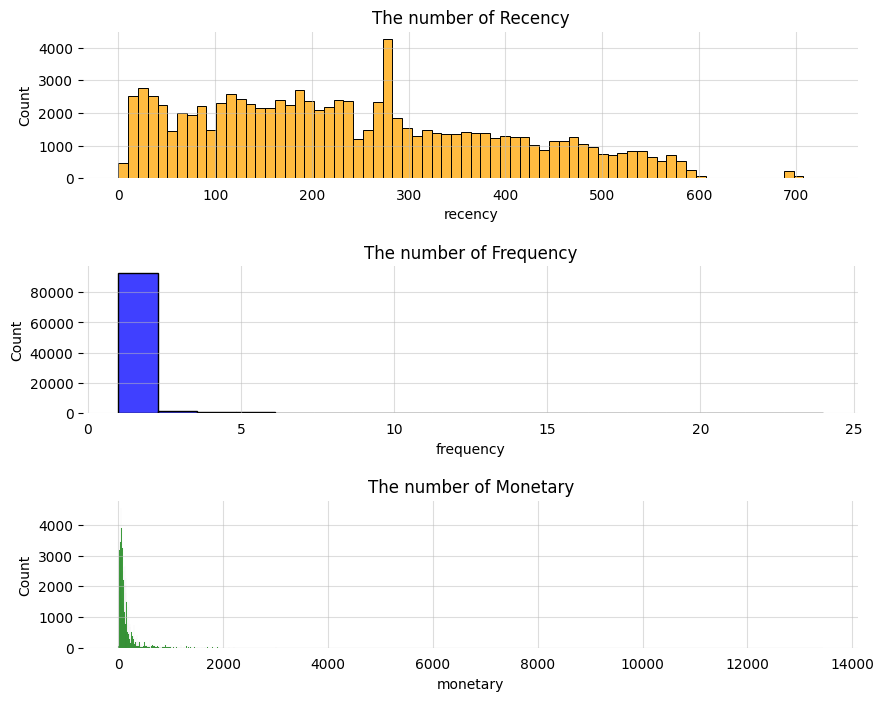

In [42]:
# Visualizing the RFM-metrics
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

colors = ['orange', 'blue', 'green']

for val, color, ax, in zip(rfm.columns.values, colors, axes.ravel()):
    sns.histplot(rfm[val]
                 , stat='count'
                 , color=color
                 , ax=ax)    
    ax.set(title='The number of {}'.format(val.capitalize()))
    ax.set_frame_on(False)
    ax.grid(True, color='#bcbcbc', alpha=0.5)
    ax.tick_params(bottom=False, which='both')

plt.subplots_adjust(hspace = 0.6)
plt.show()

*The `frequency` value needs to be split manually due to uneven data distribution*.

*Range limits:*
- 1 - *one and two purchases*;
- 2 - *2 to 6 purchases*;
- 3 - *6 to 11 purchases*;
- 4 - *from 11 to 24 purchases*.

In [43]:
# Creating a function to split the frequency
def check_frequency(x):
    if 0 < x <= 2:
        return 1
    elif 2 < x <= 6:
        return 2
    elif 6 < x <= 11:
        return 3
    elif 11 < x <= 24:
        return 4

In [44]:
# Splitting RFM values ​​into ranges
rfm['r'] = pd.qcut(rfm.recency, 4, [4, 3, 2, 1])
rfm['f'] = rfm.frequency\
                        .apply(check_frequency)
rfm['m'] = pd.qcut(rfm.monetary, 4, [1, 2, 3, 4])

In [45]:
# Sorting by frequency of purchases in descending order
rfm.sort_values('f', ascending=False).head()

,recency,frequency,monetary,r,f,m
customer_unique_id,,,,,,
c8460e4251689ba205045f3ea17884a1,25,24,4080.00,4,4,4
7582a5a77fc2976628f46a13ec91b375,143,13,389.87,3,4,4
86df00dc5fd68f4dd5d5945ca19f3ed6,324,12,2200.00,2,4,4
ca77025e7201e3b30c44b472ff346268,93,12,806.61,4,4,4
ce9f8b9c31d83341764708396ac7e38b,328,12,248.40,2,4,4


In [46]:
# Creating a function to combine RFM values ​​and create RFM segments
def combine_rfm(x):
    return str(int(x['r'])) + str(int(x['f'])) + str(int(x['m']))

In [47]:
# Creating an RFM segmentation column
rfm['rfm_segments'] = rfm.apply(combine_rfm, axis=1)\
                            .astype('int64')

rfm.head()

,recency,frequency,monetary,r,f,m,rfm_segments
customer_unique_id,,,,,,,
c8460e4251689ba205045f3ea17884a1,25,24,4080.00,4,4,4,444
4546caea018ad8c692964e3382debd19,413,21,31.80,1,4,1,141
c402f431464c72e27330a67f7b94d4fb,192,20,2000.00,3,4,4,344
698e1cf81d01a3d389d96145f7fa6df8,375,20,1974.00,1,4,4,144
0f5ac8d5c31de21d2f25e24be15bbffb,279,18,1252.35,2,4,4,244


In [48]:
rfm_num_uniq = rfm.groupby('rfm_segments')['rfm_segments']\
                    .nunique()\
                    .sum()

print('The dataframe contains {} unique RFM segments'.format(rfm_num_uniq))

The dataframe contains 45 unique RFM segments


In [49]:
# Calculating the score of RFM segments for further partition of users
rfm['rfm_score'] = rfm[['r', 'f', 'm']].sum(axis=1)

rfm.head()

,recency,frequency,monetary,r,f,m,rfm_segments,rfm_score
customer_unique_id,,,,,,,,
c8460e4251689ba205045f3ea17884a1,25,24,4080.00,4,4,4,444,12
4546caea018ad8c692964e3382debd19,413,21,31.80,1,4,1,141,6
c402f431464c72e27330a67f7b94d4fb,192,20,2000.00,3,4,4,344,11
698e1cf81d01a3d389d96145f7fa6df8,375,20,1974.00,1,4,4,144,9
0f5ac8d5c31de21d2f25e24be15bbffb,279,18,1252.35,2,4,4,244,10


*All users can be conditionally divided into levels:*
- **gold** - *the best users who buy often, regularly and for a large amount*;
- **silver** - *the average users with the middle income*;
- **bronze** - *users with the lowest income*.

In [50]:
# Creating a function to separate users into levels
def rfm_level(df):
    if df['rfm_score'] >= 10:
        return 'gold'
    elif df['rfm_score'] >= 7 and df['rfm_score'] < 10:
        return 'silver'
    return 'bronze'

In [51]:
# Creating RFM level column
rfm['rfm_level'] = rfm.apply(rfm_level, axis=1)

rfm.head()

,recency,frequency,monetary,r,f,m,rfm_segments,rfm_score,rfm_level
customer_unique_id,,,,,,,,,
c8460e4251689ba205045f3ea17884a1,25,24,4080.00,4,4,4,444,12,gold
4546caea018ad8c692964e3382debd19,413,21,31.80,1,4,1,141,6,bronze
c402f431464c72e27330a67f7b94d4fb,192,20,2000.00,3,4,4,344,11,gold
698e1cf81d01a3d389d96145f7fa6df8,375,20,1974.00,1,4,4,144,9,silver
0f5ac8d5c31de21d2f25e24be15bbffb,279,18,1252.35,2,4,4,244,10,gold


In [52]:
# Calculating average values ​​for each RFM level and its size
rfm_levels = rfm.groupby('rfm_level')\
                .agg({'recency': 'mean'
                     , 'frequency': 'mean'
                     , 'monetary': ['mean', 'count']})\
                .round(1)\
                .sort_values(('monetary', 'count'))

rfm_levels

recency frequency monetary       
             mean      mean     mean  count
rfm_level                                  
gold         76.1       4.7    491.1    544
silver      139.8       1.3    225.9  35873
bronze      306.6       1.1     88.5  59003

*As you can see, `bronze` level users occupy a large share, the number of the best users of the `gold` level is **544 pcs**.*

#### Conducting a more detailed analysis and segmentation of users

*Creating a conditional division of users into user segments:*
- **best_customers**-*customers who bought most recently are the most frequent and spend the most. Do not require any price incentives*;
- **loyal_customers**-*customers who made purchases recently buy quite often and spend the most*;
- **recent_customers**-*recent customers who haven't bought much yet, but who can potentially grow to the level of `loyal_customers` and `best_customers`*;
- **almost_lost_customers**-*customers who have not bought anything for a long time, although their purchases were quite frequent or large, and who need to be encouraged to make purchases in some way*;
- **lost_customers**-*customers who haven't bought anything for a very long time, but when they were active, their purchases were quite frequent or large*;
- **lost_cheap_customers**-*customers who haven't bought anything for a very long time, and when their purchases were active, they were rare or small in amount. Don’t need to spend the budget on restoring activity on them*;
- **normal_customers**-*other customers on which a general marketing campaign can be run*.

In [53]:
# Creating a function to segment users
def segmentation(df):
    column = df['rfm_segments']
    
    if column in [444, 434]:
        return 'best_customers'
    elif column in [344, 433, 443, 442, 424, 334]:
        return 'loyal_customers'
    elif column in [411, 412, 413, 414, 421, 431, 441, 422]:
        return 'recent_customers'
    elif column in [244, 233, 224, 231, 214, 234]:
        return 'almost_lost_customers'
    elif column in [144, 134, 124, 133, 143, 123]:
        return 'lost_customers'
    elif column in [122, 132, 142]:
        return 'lost_cheap_customers'
    else:
        return 'normal_customers'

In [54]:
# Creating an RFM user segmentation column
rfm['segmentation'] = rfm.apply(segmentation, axis=1)

rfm.head()

,recency,frequency,monetary,r,f,m,rfm_segments,rfm_score,rfm_level,segmentation
customer_unique_id,,,,,,,,,,
c8460e4251689ba205045f3ea17884a1,25,24,4080.00,4,4,4,444,12,gold,best_customers
4546caea018ad8c692964e3382debd19,413,21,31.80,1,4,1,141,6,bronze,normal_customers
c402f431464c72e27330a67f7b94d4fb,192,20,2000.00,3,4,4,344,11,gold,loyal_customers
698e1cf81d01a3d389d96145f7fa6df8,375,20,1974.00,1,4,4,144,9,silver,lost_customers
0f5ac8d5c31de21d2f25e24be15bbffb,279,18,1252.35,2,4,4,244,10,gold,almost_lost_customers


In [55]:
# Calculating average values ​​for each RFM user segment and its size
rfm_segmentation = rfm.groupby('segmentation')\
                        .agg({'recency': 'mean'
                             , 'frequency': 'mean'
                             , 'monetary': ['mean', 'count']})\
                        .round(1)\
                        .sort_values(('monetary', 'count'), ascending=False)

rfm_segmentation

recency frequency monetary       
                         mean      mean     mean  count
segmentation                                           
normal_customers        303.0       1.1    120.1  65077
recent_customers         61.3       1.1    139.0  23225
almost_lost_customers   283.2       1.4    350.2   5969
lost_customers          455.0       3.8    353.1    533
loyal_customers          74.3       4.3    470.8    508
lost_cheap_customers    454.1       3.5     70.9     78
best_customers           62.7       9.5    709.7     30

*As you can see, most of the customers are users of the `normal_customers` segment, which is **65050 people**, on which a general marketing campaign can be run. For the rest of the clients, it is necessary to create individual ways of interaction according to the characteristics of each user segment.*